**Municipaty dataset Time Series prediction problem**
Connect to colab drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Following code used to upload "municipality_bus_utilization.csv" file from computer.

In [2]:
from google.colab import files
 
 
uploaded = files.upload()

Saving municipality_bus_utilization.csv to municipality_bus_utilization.csv


Read raw csv file save as pandas dataframe

In [6]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded["municipality_bus_utilization.csv"]))
print(df.describe())
print(df.columns)

       municipality_id         usage  total_capacity
count     13070.000000  13070.000000    13070.000000
mean          4.500000    876.002984     1972.800000
std           2.872391    679.287109     1144.074782
min           0.000000     11.000000      397.000000
25%           2.000000    403.000000      697.000000
50%           4.500000    692.000000     1974.500000
75%           7.000000   1190.000000     2947.000000
max           9.000000   3508.000000     3893.000000
Index(['timestamp', 'municipality_id', 'usage', 'total_capacity'], dtype='object')


Convert date string to datetime and set as index column

In [7]:
df.timestamp.iloc[-1]
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df.set_index(['timestamp'],inplace=True)

Import matplotlib and enable inline plotting. Normalize usage values by dividing "total capacity" column. Create a new dataset which columns are usages and rows are timestamp and data. Find whether the data contains NaN values.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

new_df=pd.DataFrame({"usage"+str(i):df.iloc[np.where(df['municipality_id']==i)]["usage"]/df.iloc[np.where(df['municipality_id']==i)]["total_capacity"] for i in range(10)})   
raw_df=pd.DataFrame({"usage"+str(i):df.iloc[np.where(df['municipality_id']==i)]["usage"]/df.iloc[np.where(df['municipality_id']==i)]["total_capacity"] for i in range(10)})    
print(len(new_df))
print(new_df.isna().sum().sum())
print(new_df[new_df.isna().any(axis=1)])

1309
20
                       usage0    usage1    usage2    usage3    usage4  \
timestamp                                                               
2017-06-16 14:27:13       NaN       NaN       NaN       NaN       NaN   
2017-06-16 14:34:14  0.176680  0.851385  0.787661  0.416062  0.346263   
2017-08-11 08:19:39       NaN       NaN       NaN  0.162176       NaN   
2017-08-11 08:25:43  0.122289  0.332494  0.529412       NaN  0.200873   

                       usage5    usage6    usage7    usage8    usage9  
timestamp                                                              
2017-06-16 14:27:13  0.321976       NaN       NaN       NaN       NaN  
2017-06-16 14:34:14       NaN  0.315773  0.640911  0.297591  0.566066  
2017-08-11 08:19:39       NaN       NaN       NaN       NaN       NaN  
2017-08-11 08:25:43  0.018739  0.259557  0.366023  0.152698  0.284535  


We observed 4 rows has nan values. Consecutive pairs are merged to last timestamp. 

In [9]:
for t in range(1,len(new_df)):
    if new_df.iloc[t].isna().any() and new_df.iloc[t-1].isna().any():
        target_ind=np.where(new_df.iloc[t-1].isna()==False)[0][0]
        new_df.iloc[t][new_df.columns[target_ind]]=new_df.iloc[t-1][new_df.columns[target_ind]]
        print(new_df.iloc[t].to_dict())
        print(new_df.iloc[t-1].to_dict())
print("Merge completed")
new_df.dropna(inplace=True)
print("******************")
print(new_df[new_df.isna().any(axis=1)])

{'usage0': 0.1766797013864202, 'usage1': 0.8513853904282116, 'usage2': 0.787661406025825, 'usage3': 0.4160621761658031, 'usage4': 0.3462625224762394, 'usage5': 0.3219761499148211, 'usage6': 0.3157725666559589, 'usage7': 0.640911342248638, 'usage8': 0.2975907702748558, 'usage9': 0.566066066066066}
{'usage0': nan, 'usage1': nan, 'usage2': nan, 'usage3': nan, 'usage4': nan, 'usage5': 0.3219761499148211, 'usage6': nan, 'usage7': nan, 'usage8': nan, 'usage9': nan}
{'usage0': 0.12228937077852826, 'usage1': 0.33249370277078083, 'usage2': 0.5294117647058824, 'usage3': 0.1621761658031088, 'usage4': 0.20087336244541484, 'usage5': 0.018739352640545145, 'usage6': 0.2595566977192419, 'usage7': 0.3660227835562159, 'usage8': 0.15269765863590093, 'usage9': 0.28453453453453453}
{'usage0': nan, 'usage1': nan, 'usage2': nan, 'usage3': 0.1621761658031088, 'usage4': nan, 'usage5': nan, 'usage6': nan, 'usage7': nan, 'usage8': nan, 'usage9': nan}
Merge completed
******************
Empty DataFrame
Columns: [u

Check if there is a larger delay (more than 45 minutes) between two consequent rows. Exclude end of day to start of the next day switches if days are consequent. 

In [10]:
for t in range(1,len(new_df)):
    start = pd.to_datetime("16:15:00").time()
    end = pd.to_datetime("16:45:00").time()

    if (new_df.iloc[t].name-new_df.iloc[t-1].name)>pd.Timedelta(minutes=45) and not (new_df.iloc[t-1].name.time()>=start and new_df.iloc[t-1].name.time() <= end and (new_df.iloc[t].name-new_df.iloc[t-1].name)<pd.Timedelta(hours=17)):
        print(f"Big gap between : {new_df.iloc[t].name} and {new_df.iloc[t-1].name} Difference {new_df.iloc[t].name-new_df.iloc[t-1].name}")

Big gap between : 2017-06-22 07:59:45 and 2017-06-19 16:25:03 Difference 2 days 15:34:42
Big gap between : 2017-07-18 09:27:07 and 2017-07-18 08:27:05 Difference 0 days 01:00:02
Big gap between : 2017-07-25 09:00:56 and 2017-07-25 08:00:57 Difference 0 days 00:59:59
Big gap between : 2017-08-01 08:05:40 and 2017-07-30 16:28:40 Difference 1 days 15:37:00
Big gap between : 2017-08-05 08:02:03 and 2017-08-02 16:32:54 Difference 2 days 15:29:09
Big gap between : 2017-08-13 13:55:56 and 2017-08-13 13:02:55 Difference 0 days 00:53:01
Big gap between : 2017-08-14 11:30:01 and 2017-08-14 10:30:01 Difference 0 days 01:00:00


Check how many instances counted for each week days.

In [11]:
day_meas={i:[] for i in range(7)}
count=0
for t in range(len(new_df)-1):
    day=new_df.iloc[t].name.dayofweek
    count+=1
    if new_df.iloc[t].name.dayofweek!=new_df.iloc[t+1].name.dayofweek:
        day_meas[new_df.iloc[t].name.dayofweek].append(count)
        if count>18:
            print(new_df.iloc[t].name)
            
        count=0
print(day_meas)


2017-06-30 16:26:06
{0: [18, 18, 18, 18, 18, 18, 18, 18, 18, 17], 1: [18, 18, 18, 18, 18, 17, 17, 18, 18, 18], 2: [18, 18, 17, 18, 18, 18, 18, 18, 18, 18], 3: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18], 4: [18, 18, 18, 34, 18, 18, 18, 18, 18, 18], 5: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18], 6: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17]}


We found 34 instances are given in one Thursday. In that day (2017-06-30), closer measurements should be merged by maxing two values. 

In [12]:
for t in range(len(new_df)-1):
    if(new_df.iloc[t+1].name-new_df.iloc[t].name)<pd.Timedelta(minutes=10):
        new_df.iloc[t+1]=pd.DataFrame([new_df.iloc[t],new_df.iloc[t+1]]).max(axis=0)
        new_df.iloc[t]=np.nan
        print(f"{new_df.iloc[t].name} is dropped.")
new_df.dropna(inplace=True)

2017-06-30 07:59:55 is dropped.
2017-06-30 08:25:53 is dropped.
2017-06-30 08:59:52 is dropped.
2017-06-30 09:25:57 is dropped.
2017-06-30 09:59:52 is dropped.
2017-06-30 10:25:54 is dropped.
2017-06-30 10:59:56 is dropped.
2017-06-30 11:25:55 is dropped.
2017-06-30 11:59:58 is dropped.
2017-06-30 12:26:06 is dropped.
2017-06-30 13:00:06 is dropped.
2017-06-30 13:25:59 is dropped.
2017-06-30 13:59:47 is dropped.
2017-06-30 14:26:05 is dropped.
2017-06-30 15:00:00 is dropped.
2017-06-30 15:27:04 is dropped.


We need to inspect whether the merging process is succeeded or not. 

In [13]:
date = pd.to_datetime("2017-06-30")
mask = (new_df.index >= date) & (new_df.index < date + pd.Timedelta(days=1))
df_date = new_df[mask]
print(df_date)

                       usage0    usage1    usage2    usage3    usage4  \
timestamp                                                               
2017-06-30 08:00:03  0.050124  0.198992  0.496413  0.299482  0.273825   
2017-06-30 08:26:02  0.069321  0.239295  0.497848  0.377202  0.374261   
2017-06-30 09:00:00  0.092784  0.324937  0.586801  0.487565  0.519137   
2017-06-30 09:26:03  0.107714  0.387909  0.657102  0.566321  0.610069   
2017-06-30 10:00:05  0.128688  0.498741  0.715925  0.639378  0.685846   
2017-06-30 10:26:02  0.141841  0.534005  0.756098  0.660104  0.710506   
2017-06-30 11:00:02  0.152862  0.566751  0.774749  0.680829  0.737221   
2017-06-30 11:26:04  0.159972  0.579345  0.793400  0.683938  0.748266   
2017-06-30 12:00:04  0.169925  0.667506  0.822095  0.688083  0.745184   
2017-06-30 12:26:54  0.190544  0.692695  0.835007  0.691710  0.741587   
2017-06-30 13:06:59  0.258443  0.778338  0.868006  0.695855  0.746468   
2017-06-30 13:26:01  0.306434  0.823678  0.883788  

Count now how many instances observed each day. We have 18 or 17 instances per day.

In [14]:
day_meas={i:[] for i in range(7)}
old_day=6
count=0
for t in range(len(new_df)-1):
    day=new_df.iloc[t].name.dayofweek
    count+=1
    if new_df.iloc[t].name.dayofweek!=new_df.iloc[t+1].name.dayofweek:
        day_meas[new_df.iloc[t].name.dayofweek].append(count)
        if count>18:
            print(new_df.iloc[t].name)
            
        count=0
print(day_meas)

{0: [18, 18, 18, 18, 18, 18, 18, 18, 18, 17], 1: [18, 18, 18, 18, 18, 17, 17, 18, 18, 18], 2: [18, 18, 17, 18, 18, 18, 18, 18, 18, 18], 3: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18], 4: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18], 5: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18], 6: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17]}


We merged half hourly data into hourly data by maxing out measurements.

In [15]:
t=0
while(t<(len(new_df)-1)):
    if new_df.iloc[t].name.dayofweek==new_df.iloc[t+1].name.dayofweek:
        new_df.iloc[t+1]=pd.DataFrame([new_df.iloc[t],new_df.iloc[t+1]]).max(axis=0)
        new_df.iloc[t]=np.nan
        t+=2
    else:
        t+=1
new_df.dropna(inplace=True)
day_meas={i:[] for i in range(7)}

count=0
for t in range(len(new_df)-1):
    day=new_df.iloc[t].name.dayofweek
    count+=1
    if new_df.iloc[t].name.dayofweek!=new_df.iloc[t+1].name.dayofweek:
        day_meas[new_df.iloc[t].name.dayofweek].append(count)
        if count>18:
            print(new_df.iloc[t].name)
            
        count=0
print(day_meas)
print(new_df.describe())

{0: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 1: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 2: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 3: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 4: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 5: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 6: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]}
           usage0      usage1      usage2      usage3      usage4      usage5  \
count  648.000000  648.000000  648.000000  648.000000  648.000000  648.000000   
mean     0.202953    0.775885    0.718828    0.580485    0.616071    0.307575   
std      0.085897    0.220756    0.169977    0.184879    0.218912    0.170845   
min      0.024884    0.148615    0.265423    0.148705    0.134857    0.020443   
25%      0.159172    0.649244    0.597561    0.423187    0.424608    0.192078   
50%      0.198009    0.833753    0.751076    0.630052    0.682507    0.296422   
75%      0.226449    0.950252    0.849713    0.731088    0.805870    0.377342   
max      0.548525    1.037783    1.000000    0.852850    0.901105    0.991482   

           usage6    

We are checking the whether merging process is succeeded or not. Generally we have measurements for each hour but in 4 days we skipped some hours.

In [16]:
print(f" Minimum hour {new_df.index.hour.min()} Maximum hour {new_df.index.hour.max()}")
count=1
for t in range(len(new_df)-1):
    if new_df.iloc[t].name.hour!=new_df.iloc[t+1].name.hour and new_df.iloc[t].name.dayofweek==new_df.iloc[t+1].name.dayofweek:
        count+=1
    elif new_df.iloc[t].name.hour==new_df.iloc[t+1].name.hour:
        print(f"{new_df.iloc[t-1].name},{new_df.iloc[t].name},{new_df.iloc[t+1].name},{new_df.iloc[t+2].name}")
    elif new_df.iloc[t].name.dayofweek!=new_df.iloc[t+1].name.dayofweek:
        if count!=9:
            print(f"Day {new_df.iloc[t].name.date()} , Hour count is : {count}")
        count=1


 Minimum hour 8 Maximum hour 16
2017-06-28 08:56:40,2017-06-28 10:02:44,2017-06-28 10:56:43,2017-06-28 12:02:44
2017-06-28 15:02:43,2017-06-28 16:02:40,2017-06-28 16:29:42,2017-06-29 08:26:46
Day 2017-06-28 , Hour count is : 7
2017-07-18 15:01:07,2017-07-18 16:01:10,2017-07-18 16:28:10,2017-07-19 08:31:12
Day 2017-07-18 , Hour count is : 8
2017-07-25 15:00:56,2017-07-25 16:00:59,2017-07-25 16:27:58,2017-07-26 08:28:01
Day 2017-07-25 , Hour count is : 8
2017-08-13 14:56:52,2017-08-13 16:02:56,2017-08-13 16:29:56,2017-08-14 08:43:00
Day 2017-08-13 , Hour count is : 8
2017-08-14 13:03:02,2017-08-14 14:03:00,2017-08-14 14:56:03,2017-08-14 15:56:02
Day 2017-08-14 , Hour count is : 8


We are filling missing datas by averaging the same day same hour datas observed in one week ago and after.

In [17]:
print(f"Previous size of DF is : {len(new_df)}")
empty_df=pd.DataFrame()
for t in range(1,len(new_df)):
    if (new_df.iloc[t].name-new_df.iloc[t-1].name)>pd.Timedelta(hours=24):
        print(f"Big gap between : {new_df.iloc[t].name} and {new_df.iloc[t-1].name} Difference {new_df.iloc[t].name-new_df.iloc[t-1].name}")
        for i in range((new_df.iloc[t].name-new_df.iloc[t-1].name).days):
            cols=[new_df.iloc[t-9].name+pd.Timedelta(days=i+1)+pd.Timedelta(hours=j) for j in range(9)]
            datp=(new_df.iloc[t-9].name.date()+pd.Timedelta(days=i-7))
            datf=(new_df.iloc[t-9].name.date()+pd.Timedelta(days=i+7))
            print(cols,datp,datf)
            dat=0.5*(new_df.loc[datp:datp+pd.Timedelta(days=1)].to_numpy())+0.5*(new_df.loc[datf:datf+pd.Timedelta(days=1)].to_numpy())
            #print(dat.shape)
            ex_df=pd.DataFrame(data=dat,index=cols,columns=["usage"+str(j) for j in range(10)])
            #print(ex_df)
            empty_df=pd.concat([empty_df, ex_df])
            
            print("*****************")
            #print(new_df.loc[datp:datp+pd.Timedelta(days=1)])
            #print(new_df.loc[datf:datf+pd.Timedelta(days=1)])
            print(cols)
new_df=pd.concat([new_df,empty_df],join="inner")
print(f"Current size of DF is : {len(new_df)}")
           

Previous size of DF is : 648
Big gap between : 2017-06-22 08:26:46 and 2017-06-19 16:25:03 Difference 2 days 16:01:43
[Timestamp('2017-06-20 08:25:01'), Timestamp('2017-06-20 09:25:01'), Timestamp('2017-06-20 10:25:01'), Timestamp('2017-06-20 11:25:01'), Timestamp('2017-06-20 12:25:01'), Timestamp('2017-06-20 13:25:01'), Timestamp('2017-06-20 14:25:01'), Timestamp('2017-06-20 15:25:01'), Timestamp('2017-06-20 16:25:01')] 2017-06-12 2017-06-26
*****************
[Timestamp('2017-06-20 08:25:01'), Timestamp('2017-06-20 09:25:01'), Timestamp('2017-06-20 10:25:01'), Timestamp('2017-06-20 11:25:01'), Timestamp('2017-06-20 12:25:01'), Timestamp('2017-06-20 13:25:01'), Timestamp('2017-06-20 14:25:01'), Timestamp('2017-06-20 15:25:01'), Timestamp('2017-06-20 16:25:01')]
[Timestamp('2017-06-21 08:25:01'), Timestamp('2017-06-21 09:25:01'), Timestamp('2017-06-21 10:25:01'), Timestamp('2017-06-21 11:25:01'), Timestamp('2017-06-21 12:25:01'), Timestamp('2017-06-21 13:25:01'), Timestamp('2017-06-21 1

After appending missing data we are sorting data w.r.t date.

In [18]:
new_df=new_df.sort_index(ascending=True)
new_df.to_csv("combined.csv")

Now I visualized the raw and manipulated data to demonstrate differences.

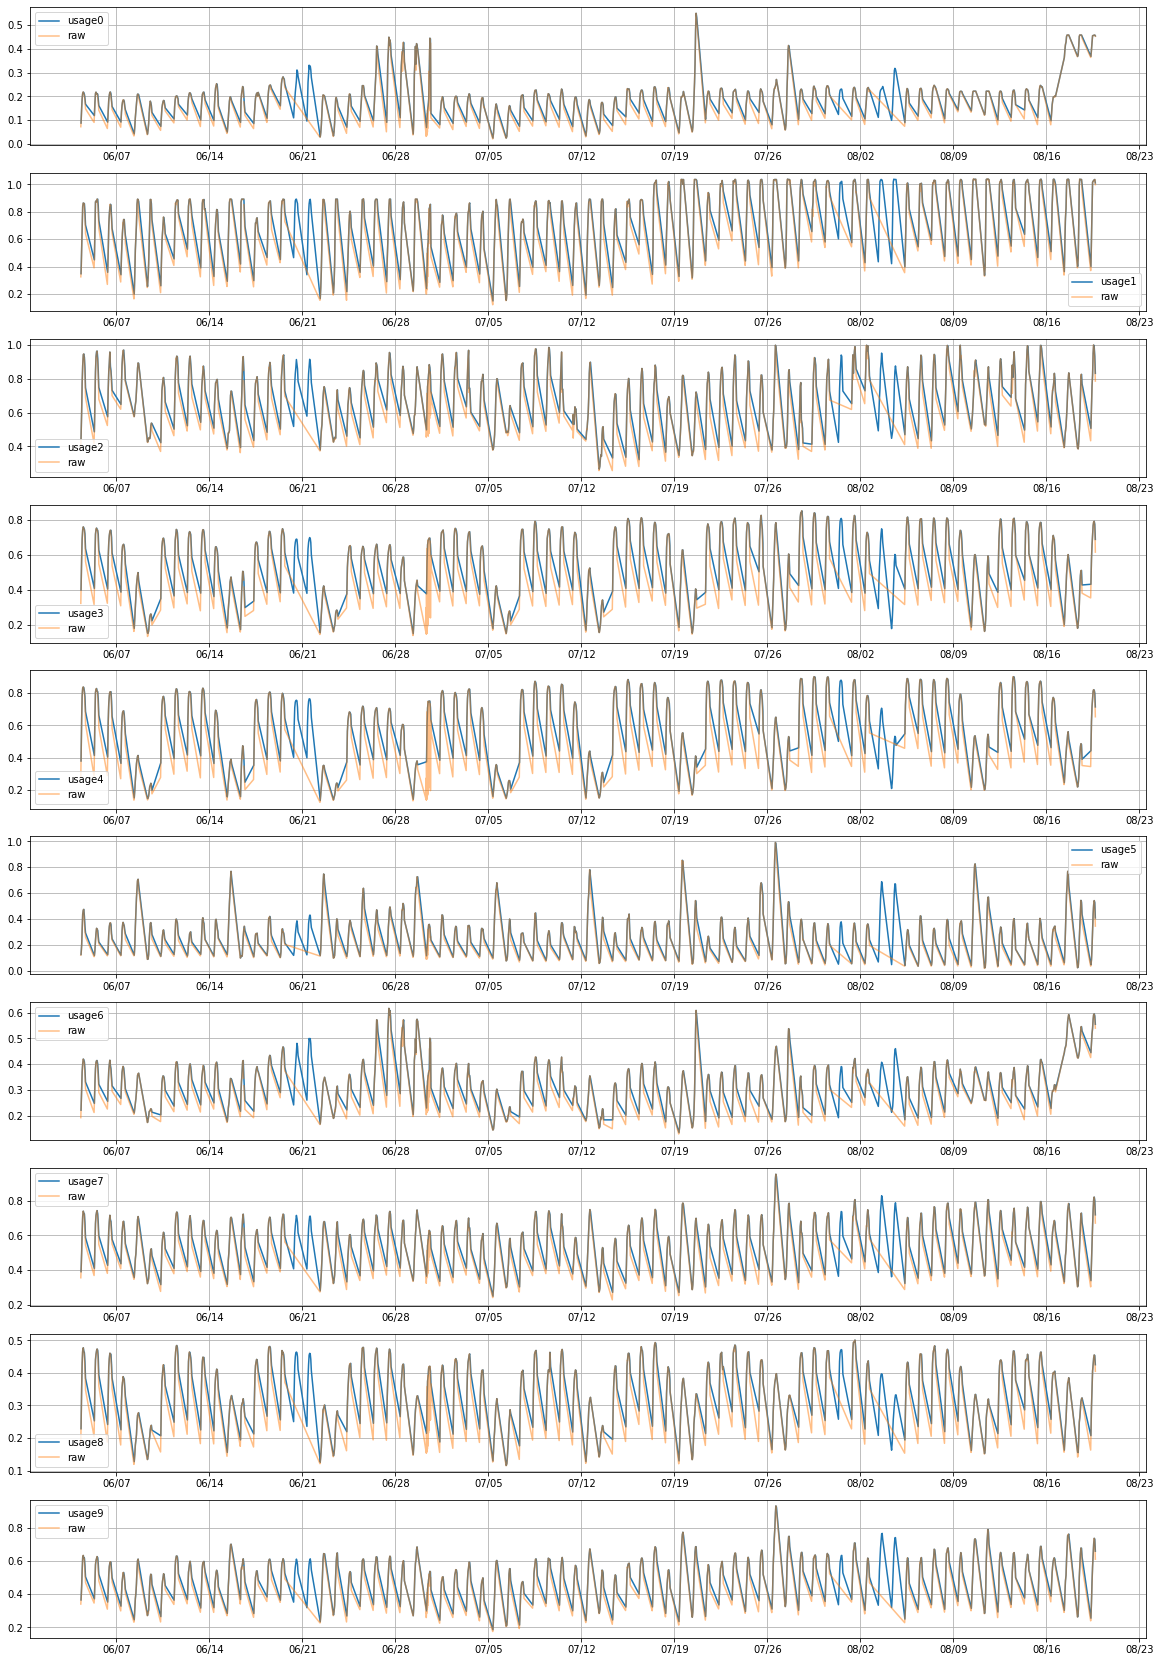

In [19]:
fig, axs = plt.subplots(10, 1,figsize=(20,30))
from matplotlib.dates import DateFormatter,ConciseDateFormatter,DayLocator
for i in range(10):
    axs[i].plot(new_df['usage'+str(i)],label='usage'+str(i))
    axs[i].plot(raw_df['usage'+str(i)],alpha=0.5,label="raw")
    date_form = DateFormatter("%m/%d")
    #axs[i].xaxis.set_major_formatter(ConciseDateFormatter(axs[i].xaxis.get_major_locator()))
    axs[i].xaxis.set_major_locator(DayLocator(interval=7))
    axs[i].xaxis.set_major_formatter(date_form)
   
    axs[i].grid(True)
    axs[i].legend()


We used minmax scaler for LSTM model and differencing for AR Model. We also splitted data into train and test data (after the date "2017-08-05")

In [20]:
from sklearn.preprocessing import MinMaxScaler

date = pd.to_datetime("2017-08-05")
test_mask = (new_df.index >= date)
n_test=test_mask.sum()
print(f"Number of test instances : {n_test}")
copy_df=new_df.copy(deep=True)
copy_df=copy_df.reset_index(drop=True)

diff_df=copy_df-copy_df.shift(1)
diff_df=diff_df.dropna()
print(diff_df.head(5))
train_df=diff_df.iloc[:-n_test]
test_df=diff_df.iloc[-n_test:]

scale = MinMaxScaler()
scaled_df = pd.DataFrame(scale.fit_transform(copy_df.values), columns=copy_df.columns, index=copy_df.index)
train_df2=scaled_df.iloc[:-n_test]
test_df2=scaled_df.iloc[-n_test:]
print(scaled_df.head(5))

Number of test instances : 135
     usage0    usage1    usage2    usage3    usage4    usage5    usage6  \
1  0.064700  0.188917  0.160689  0.186528  0.265862  0.073254  0.081593   
2  0.037327  0.151134  0.166428  0.105181  0.136912  0.119250  0.067459   
3  0.022396  0.151134  0.106169  0.053886  0.047778  0.119250  0.031802   
4  0.006043  0.025189  0.063128  0.016580  0.007706  0.032368  0.017989   
5 -0.003199 -0.002519  0.004304 -0.006218 -0.004881  0.005111 -0.002891   

     usage7    usage8    usage9  
1  0.110946  0.125891  0.084084  
2  0.119366  0.074992  0.093844  
3  0.088658  0.038005  0.078829  
4  0.029718  0.009501  0.012012  
5 -0.011392 -0.010180 -0.018769  
     usage0    usage1    usage2    usage3    usage4    usage5    usage6  \
0  0.120163  0.223796  0.246094  0.355408  0.318807  0.107018  0.180186   
1  0.243720  0.436261  0.464844  0.620309  0.665773  0.182456  0.349069   
2  0.315003  0.606232  0.691406  0.769684  0.844452  0.305263  0.488697   
3  0.357773  0

Checking the dimensions

In [21]:
print(f"Train data size is : {len(train_df)} and Test data size is : {len(test_df)}")

Train data size is : 557 and Test data size is : 135


Stationary tests function definition and test raw dataset.

In [22]:
from statsmodels.tsa.stattools import adfuller,kpss
import warnings

warnings.filterwarnings("ignore")

def check_stationarity(df, significance_level=0.05):
    """
    Check if a time series data is stationary using both the ADF and KPSS tests.
    
    Parameters:
    - df (Pandas DataFrame): The data to be tested.
    - target_column (str): The name of the target column in the DataFrame.
    - significance_level (float): The significance level to use for the tests (default is 0.05).
    
    Returns:
    - A tuple of two booleans, indicating the results of the ADF and KPSS tests respectively.
    """
    # Perform the ADF test
    adf_test_statistic, adf_p_value,_,_, adf_critical_values,adf_hypothesis_results = adfuller(df.values)
  
    # Check the ADF test results
    adf_result = (adf_test_statistic < adf_critical_values['5%'])
    
    # Perform the KPSS test
    kpss_test_statistic, kpss_p_value, kpss_critical_values, kpss_hypothesis_results = kpss(df.values)
    
    # Check the KPSS test results
    kpss_result = (kpss_p_value > significance_level)
    
    return (adf_result, kpss_result)

for i in range(10):
  (adf_res,kpss_res) = check_stationarity(new_df["usage"+str(i)])
  print(f"usage{(i)} results are {(adf_res,kpss_res)}")
  if adf_res and kpss_res:
    print("usage"+str(i)+" is stationary!")


usage0 results are (False, False)
usage1 results are (False, False)
usage2 results are (True, True)
usage2 is stationary!
usage3 results are (True, True)
usage3 is stationary!
usage4 results are (True, True)
usage4 is stationary!
usage5 results are (True, True)
usage5 is stationary!
usage6 results are (True, True)
usage6 is stationary!
usage7 results are (True, False)
usage8 results are (True, True)
usage8 is stationary!
usage9 results are (True, False)


Check whether differenced dataset is stationary.

In [23]:
for i in range(10):
  diff_df=train_df["usage"+str(i)]
  (adf_res,kpss_res) = check_stationarity(diff_df)
  print(f"usage{(i)} results are {(adf_res,kpss_res)}")
  if adf_res and kpss_res:
    print("usage"+str(i)+" is stationary!")

usage0 results are (True, True)
usage0 is stationary!
usage1 results are (True, True)
usage1 is stationary!
usage2 results are (True, True)
usage2 is stationary!
usage3 results are (True, True)
usage3 is stationary!
usage4 results are (True, True)
usage4 is stationary!
usage5 results are (True, True)
usage5 is stationary!
usage6 results are (True, True)
usage6 is stationary!
usage7 results are (True, True)
usage7 is stationary!
usage8 results are (True, True)
usage8 is stationary!
usage9 results are (True, True)
usage9 is stationary!


Train AutoRegresive Model to fit on differenced data. Plot future predictions to see relative error on this data. 

For Municipaty 0 get MSE 0.008782329500572044 
For Municipaty 1 get MSE 0.0075763114236245864 
For Municipaty 2 get MSE 0.011558065270057111 
For Municipaty 3 get MSE 0.011229814431822638 
For Municipaty 4 get MSE 0.01626597213108242 
For Municipaty 5 get MSE 0.018615650794498048 
For Municipaty 6 get MSE 0.006606929685045164 
For Municipaty 7 get MSE 0.005014016540960686 
For Municipaty 8 get MSE 0.0021427111918094813 
For Municipaty 9 get MSE 0.005333551303805737 


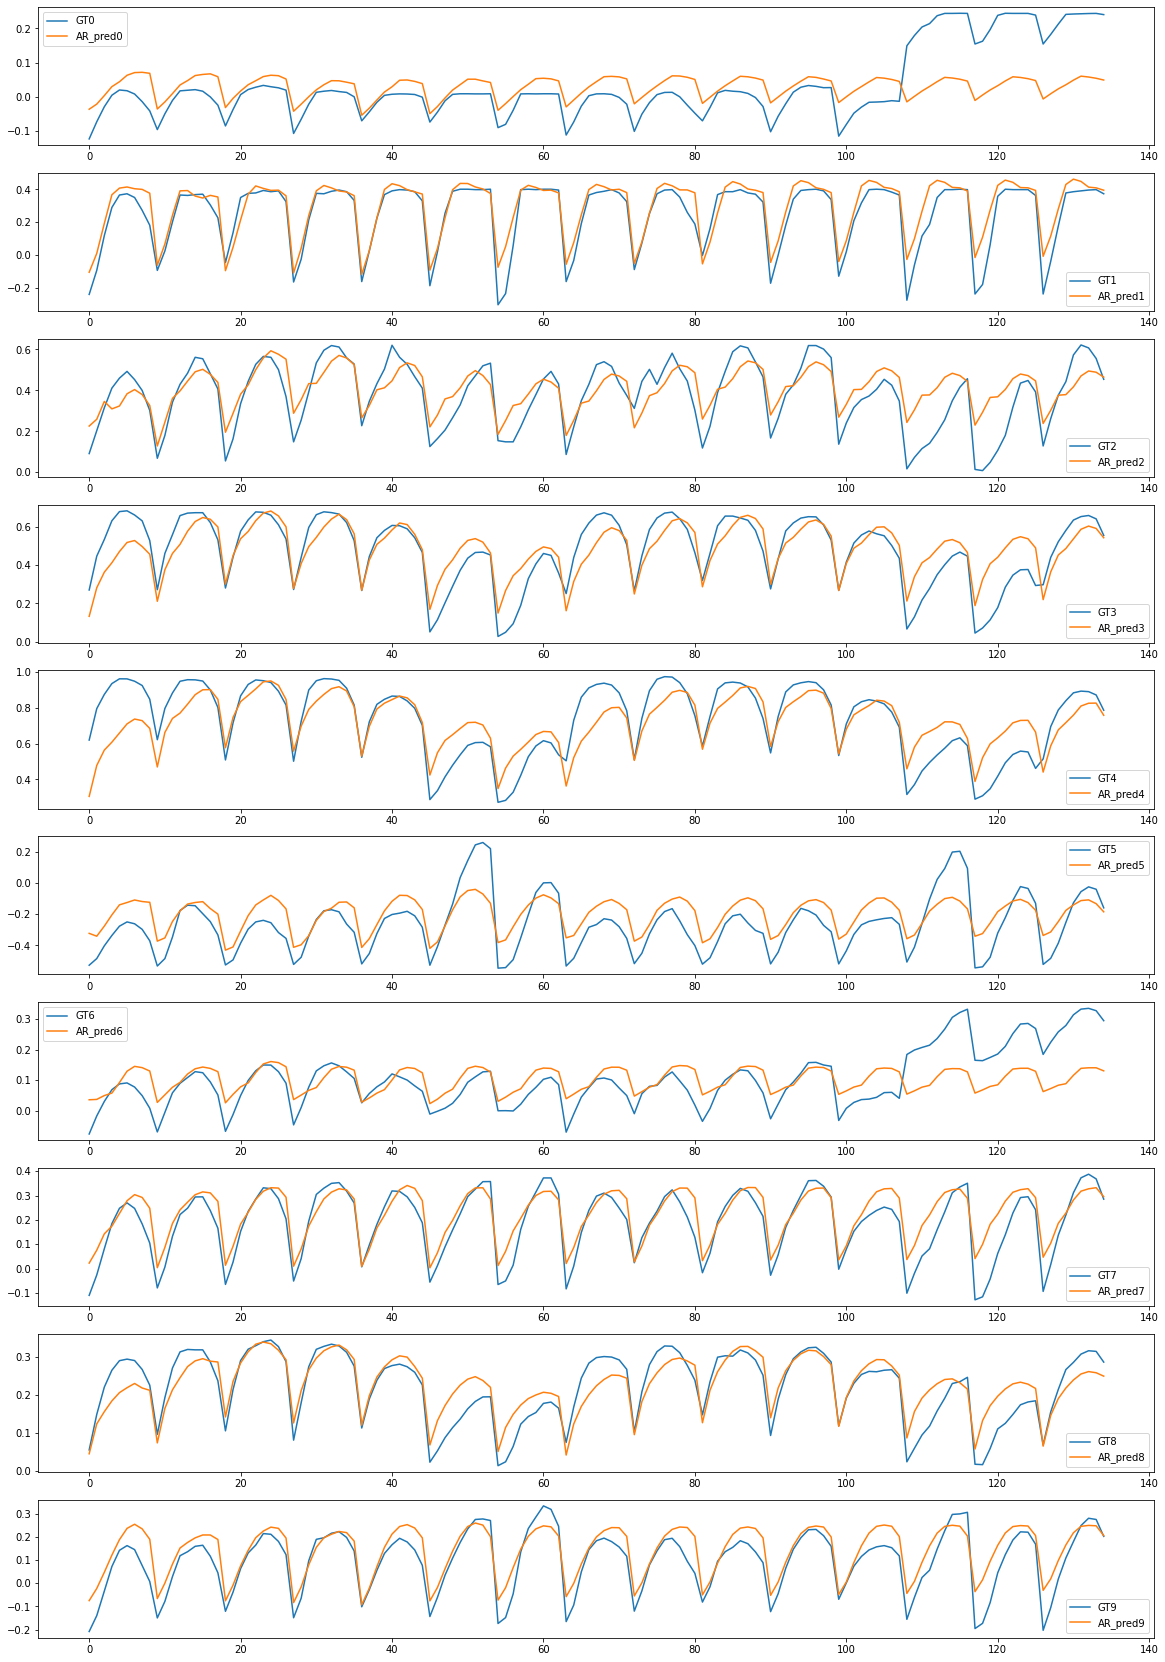

In [24]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
fig, axs = plt.subplots(10, 1,figsize=(20,30))
for i in range(10):
    AR_model = AutoReg(train_df['usage'+str(i)], lags=50,old_names=False)
    AR_model_fit = AR_model.fit()
    AR_predictions = AR_model_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, dynamic= False)
    preds=new_df.iloc[-n_test]["usage"+str(i)]+AR_predictions.cumsum()
    gt_data=new_df.iloc[-n_test]["usage"+str(i)]+test_df["usage"+str(i)].cumsum()
    axs[i].plot(range(len(gt_data)),gt_data,label="GT"+str(i))
    axs[i].plot(range(len(gt_data)),preds,label="AR_pred"+str(i))
    axs[i].legend()
    print(f"For Municipaty {i} get MSE {mean_squared_error(gt_data,preds)} ")


In [25]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

We will create a LSTM model to predict next timestep data. All requirements are imported. Split sequence function is like a dataloader.

In [26]:
def split_sequence(data, num_obs):
  X,y = [],[]
  for i in range(len(data)-num_obs):
    start = i
    end = start+num_obs
    seq_x, seq_y=data[start:end], data[end]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)
lstm_models={i:None for i in range(10)}
window=63
for i in range(10):
  print(f"Municipaty num {i}")
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)

  X,Y = split_sequence(train_df2['usage'+str(i)].values.tolist(),window)
  x_val,y_val = split_sequence(test_df2['usage'+str(i)].values.tolist(),window)

  X = X.reshape((X.shape[0], X.shape[1], 1))
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(window, 1)))
  model.add(Dense(1))
  opt = Adam(learning_rate=0.01)
  model.compile( optimizer=opt, loss='mse')
  # fit model
  model.fit(X, Y, validation_data=(x_val, y_val), callbacks=[reduce_lr], epochs=100, verbose=0)
  lstm_models[i]=model
  print("Finished")


Municipaty num 0
Finished
Municipaty num 1
Finished
Municipaty num 2
Finished
Municipaty num 3
Finished
Municipaty num 4
Finished
Municipaty num 5
Finished
Municipaty num 6
Finished
Municipaty num 7
Finished
Municipaty num 8
Finished
Municipaty num 9
Finished


Get predictions revert back to normalized versions and calculate mse error.

For Municipaty 0 get MSE 0.0020767729488251735 
For Municipaty 1 get MSE 0.04678813288400418 
For Municipaty 2 get MSE 0.027714714548431097 
For Municipaty 3 get MSE 0.0027653444108879815 
For Municipaty 4 get MSE 0.005022365228269762 
For Municipaty 5 get MSE 0.0084795181363375 
For Municipaty 6 get MSE 0.002639184039167444 
For Municipaty 7 get MSE 0.0011221852559142205 
For Municipaty 8 get MSE 0.0006058136043454594 
For Municipaty 9 get MSE 0.00174050059170917 


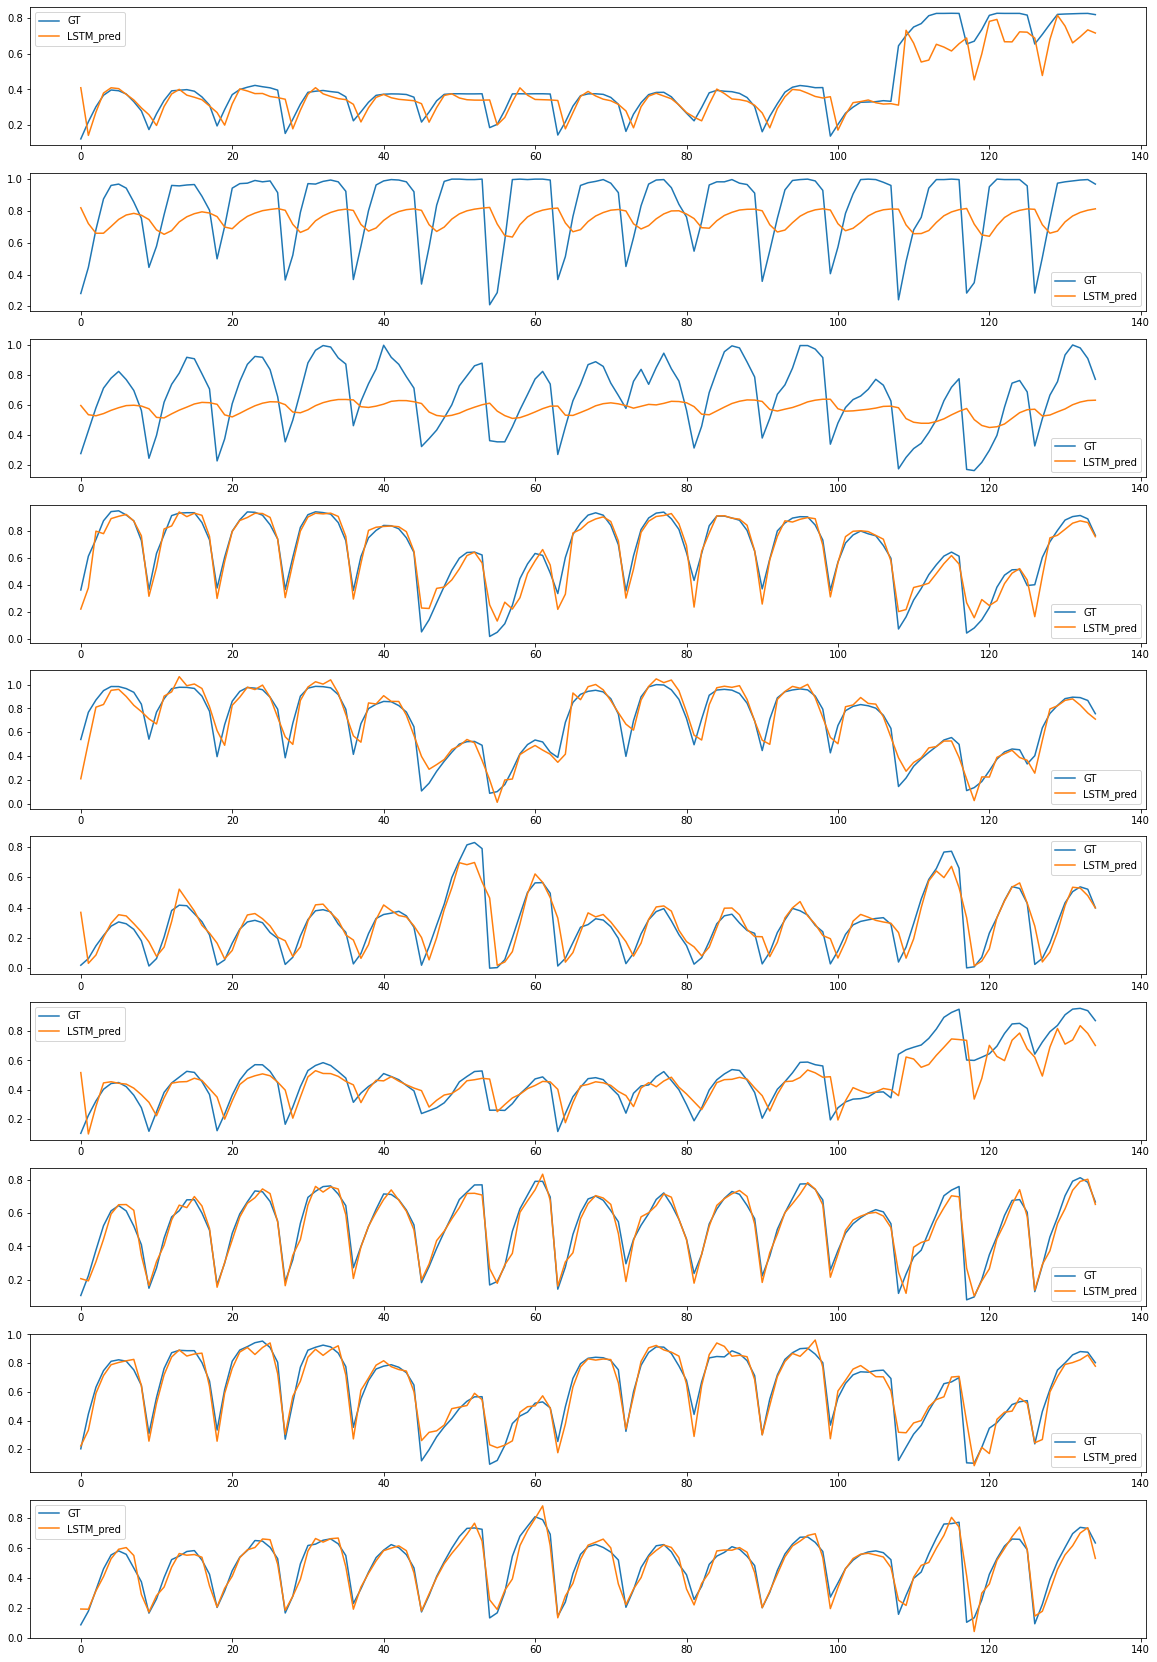

In [27]:
fig, axs = plt.subplots(10, 1,figsize=(20,30))

res_dict={}
for i in range(10):
    history=train_df2['usage'+str(i)].values.tolist()[-window:]+test_df2['usage'+str(i)].values.tolist()
    X,Y = split_sequence(history,window)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    yhat=lstm_models[i].predict(X,verbose=0)
    res_dict['usage'+str(i)]=list(yhat.reshape(-1))
    gt_data=test_df2["usage"+str(i)].values.tolist()
    axs[i].plot(range(len(gt_data)),gt_data,label="GT")
    axs[i].plot(range(len(gt_data)),list(yhat.reshape(-1)),label="LSTM_pred")
    axs[i].legend()

res_df=pd.DataFrame(res_dict)
unscaled_res=scale.inverse_transform(res_df)
for i in range(10):
  print(f"For Municipaty {i} get MSE {mean_squared_error(copy_df['usage'+str(i)].iloc[-n_test:],unscaled_res[:,i])} ")

